# 🧭 Overview

This tutorial walks you through how to read, interpret, and visualize the retrieval results.

We will load the final MCMC chains/Multinest posterior samples, model configurations, and opacity data, then prepare them for post-retrieval analysis.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import matplotlib.colors as colors
import scipy as sp
import numpy as np
import emcee
import os 
from collections import namedtuple
import settings
import utils
import test_module
import retrieval_run
import corner
import pickle as pickle
import TPmod
from specops import proc_spec
from IPython.display import display
%matplotlib inline

## 1. Load the MCMC end chains, arguments and opacities

In [3]:
path = "/Users/fw23aao/spidernail/brewster_trail/v2_master/result/"

runname = "V2_G570D_test"

# OK finish? 1 for yes, 0 for no.
fin = 0
flatendchain, flatendprobs,ndim = utils.get_endchain(runname,fin,path)
theta_max_end = flatendchain[np.argmax(flatendprobs)]
max_end_like = np.amax(flatendprobs)
samples = flatendchain

argfile =path+runname+"_runargs.pic"
runargs = utils.pickle_load(argfile)
opacityfile =path+runname+"_opacities.pic"
opacities = utils.pickle_load(opacityfile)

# cloudfile =path+runname+"_cloudata.pic"
# cloudata = utils.pickle_load(cloudfile)

settings.init(runargs)
settings.linelist=opacities[0]
settings.cia=opacities[1]
# settings.cloudata=cloudata


with open(path+runname+'_configs.pic', 'rb') as file:
    configs= pickle.load(file)
    
re_params=configs['re_params']
model_config_instance=configs['model_config']

## 2. check the maximum-likelihood parameter vector and BIC

In [19]:
# import matplotlib.pyplot as plt
# import numpy as np

# # assuming you already have:
# # flatendchain, flatendprobs, ndim, all_params

# n_params = len(all_params)
# fig, axes = plt.subplots(n_params, 1, figsize=(10, 2*n_params), sharex=True)

# for i in range(n_params):
#     ax = axes[i]
#     ax.plot(flatendchain[5000:, i], lw=0.3, alpha=0.7)
#     ax.set_ylabel(all_params[i])
#     if i == 0:
#         ax.set_title("MCMC Chain Traces for Each Parameter")

# axes[-1].set_xlabel("Iteration")
# plt.tight_layout()
# plt.show()


In [16]:
args_instance=settings.runargs
all_params,all_params_values =utils.get_all_parametres(re_params.dictionary)

params_master = namedtuple('params',all_params)
params_instance = params_master(*theta_max_end)
params_instance

params(h2o=np.float64(-3.410715344312475), co=np.float64(-5.335018182951776), co2=np.float64(-5.385811045586923), ch4=np.float64(-3.274219715773874), nh3=np.float64(-4.4574174403448446), h2s=np.float64(-8.35370258265077), K_Na=np.float64(-5.507321919463859), logg=np.float64(5.062485982503977), r2d2=np.float64(2.406899458843879e-19), dlambda=np.float64(0.0018136008096777234), tolerance_parameter_1=np.float64(-32.40126867660892), gamma=np.float64(1.5586869459107238), T_1=np.float64(92.77167202479193), T_2=np.float64(102.09788741257415), T_3=np.float64(111.91361182064097), T_4=np.float64(139.6447183893607), T_5=np.float64(190.40929377901222), T_6=np.float64(265.70149505255085), T_7=np.float64(367.90860180636776), T_8=np.float64(508.3576788553118), T_9=np.float64(695.4993860626847), T_10=np.float64(944.0065841517328), T_11=np.float64(1250.210561421892), T_12=np.float64(1592.971263266005), T_13=np.float64(1939.909500982047))

In [9]:
BIC = (-2.* max_end_like) + (ndim*np.log(runargs.obspec.shape[1]))
print("BIC = "+str(BIC))

BIC = -24728.363211978773


In [30]:
re_params.dictionary['pt']['params'].keys()

dict_keys(['gamma', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'T_6', 'T_7', 'T_8', 'T_9', 'T_10', 'T_11', 'T_12', 'T_13'])

## 3. Extract the P–T Profile from the MCMC samples.
compute the median and credible intervals (1σ and 2σ) for the atmospheric temperature structure.

In [10]:
all_params,all_params_values =utils.get_all_parametres(re_params.dictionary) 
params_master = namedtuple('params',all_params)
params_instance = params_master(*theta_max_end)

intemp_keys = list(re_params.dictionary['pt']['params'].keys())

if runargs.proftype==1 or runargs.proftype==77:
    p_index_first=params_instance._fields.index(intemp_keys[1]) 
else:
    p_index_first=params_instance._fields.index(intemp_keys[0]) 
    
p_index_last=params_instance._fields.index(intemp_keys[-1])+1

Tsamples = samples[:,p_index_first:p_index_last]
nsamps = Tsamples.shape[0]
Tprofs = np.empty([64,Tsamples.shape[0]])
for i in range(0,nsamps):
    Tprofs[:,i] = TPmod.set_prof(runargs.proftype,runargs.coarsePress,runargs.press,Tsamples[i,:])
    
Tlays = np.empty([64,5])
for i in range(0,64):
    junk = Tprofs[i,:]
    junk2 = np.percentile(junk, [2.4,16, 50, 84,97.6],axis=0)
    junk3 = np.array(junk2)
    Tlays[i,:] = junk3[:]

Text(0.5, 0, 'T / K')

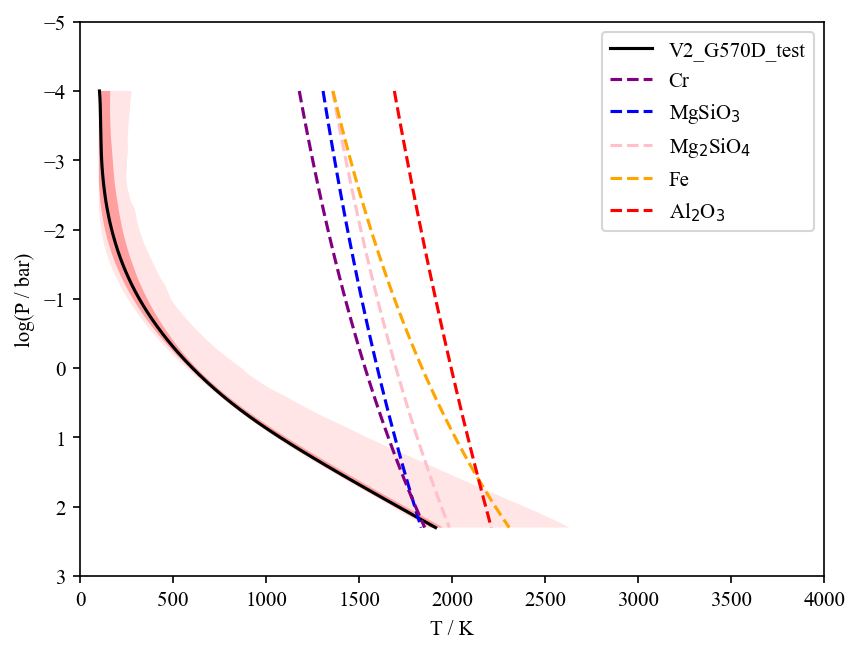

In [22]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=150)
plt.axis([0., 4000.,3.0,-5.0])

logP = np.log10(runargs.press)

d1, = plt.plot(Tlays[:,2],logP,'k-',label=runname)
plt.fill_betweenx(logP,Tlays[:,1], Tlays[:,3], facecolor='red', alpha=0.3)
plt.fill_betweenx(logP,Tlays[:,0], Tlays[:,4], facecolor='red', alpha=0.1)

# Here are some condensation curves
enst = 10.0**4/(6.26 - 0.35*logP-0.70*0.0)
fost = 10.0**4/(5.89 - 0.37*logP-0.73*0.0)
iron = 10.0**4/(5.44 - 0.48*logP-0.48*0.0)
cr =  10.0**4/(6.528 - 0.491*logP-0.491*0.0)
al2o3 = 10.0**4 / (5.0139 - 0.21794*(logP) + 2.2636E-03*(logP)**2.0 - 0.580*0.0)
c1, = plt.plot(enst,logP,'--',color='blue',linewidth=1.5, label='MgSiO$_3$')
c2, = plt.plot(fost,logP,'--',color='pink',linewidth=1.5,label='Mg$_2$SiO$_4$')
c3, = plt.plot(iron,logP,'--',color='orange',linewidth=1.5, label='Fe')
c4, = plt.plot(cr,logP,'--',color='purple',linewidth=1.5, label='Cr')
c5, = plt.plot(al2o3,logP,'--',color='red',linewidth=1.5, label='Al$_2$O$_3$')

plt.legend(handles=[d1,c4,c1,c2,c3,c5])
plt.ylabel(r'log(P / bar)')
plt.xlabel('T / K')


## 4. Check the Mass and Radius from the retrieved parameters r2d2 and logg.

In [24]:
D = 3.086e+16 * model_config_instance.dist

r2d2_index=params_instance._fields.index('r2d2')
r2d2 =theta_max_end[r2d2_index]


logg_index=params_instance._fields.index('logg')
logg =theta_max_end[logg_index]


if (r2d2 > 0.):
    R = np.sqrt(r2d2) * D
g = (10.**logg)/100.
M = (R**2 * g/(6.67E-11))/1.898E27
Rj = R / 69911.e3
print(M,Rj)

71.30819237514689 1.2647137178359216


## 5. Corner Plot
Visualize the posterior distributions of all retrieved parameters using a corner plot.

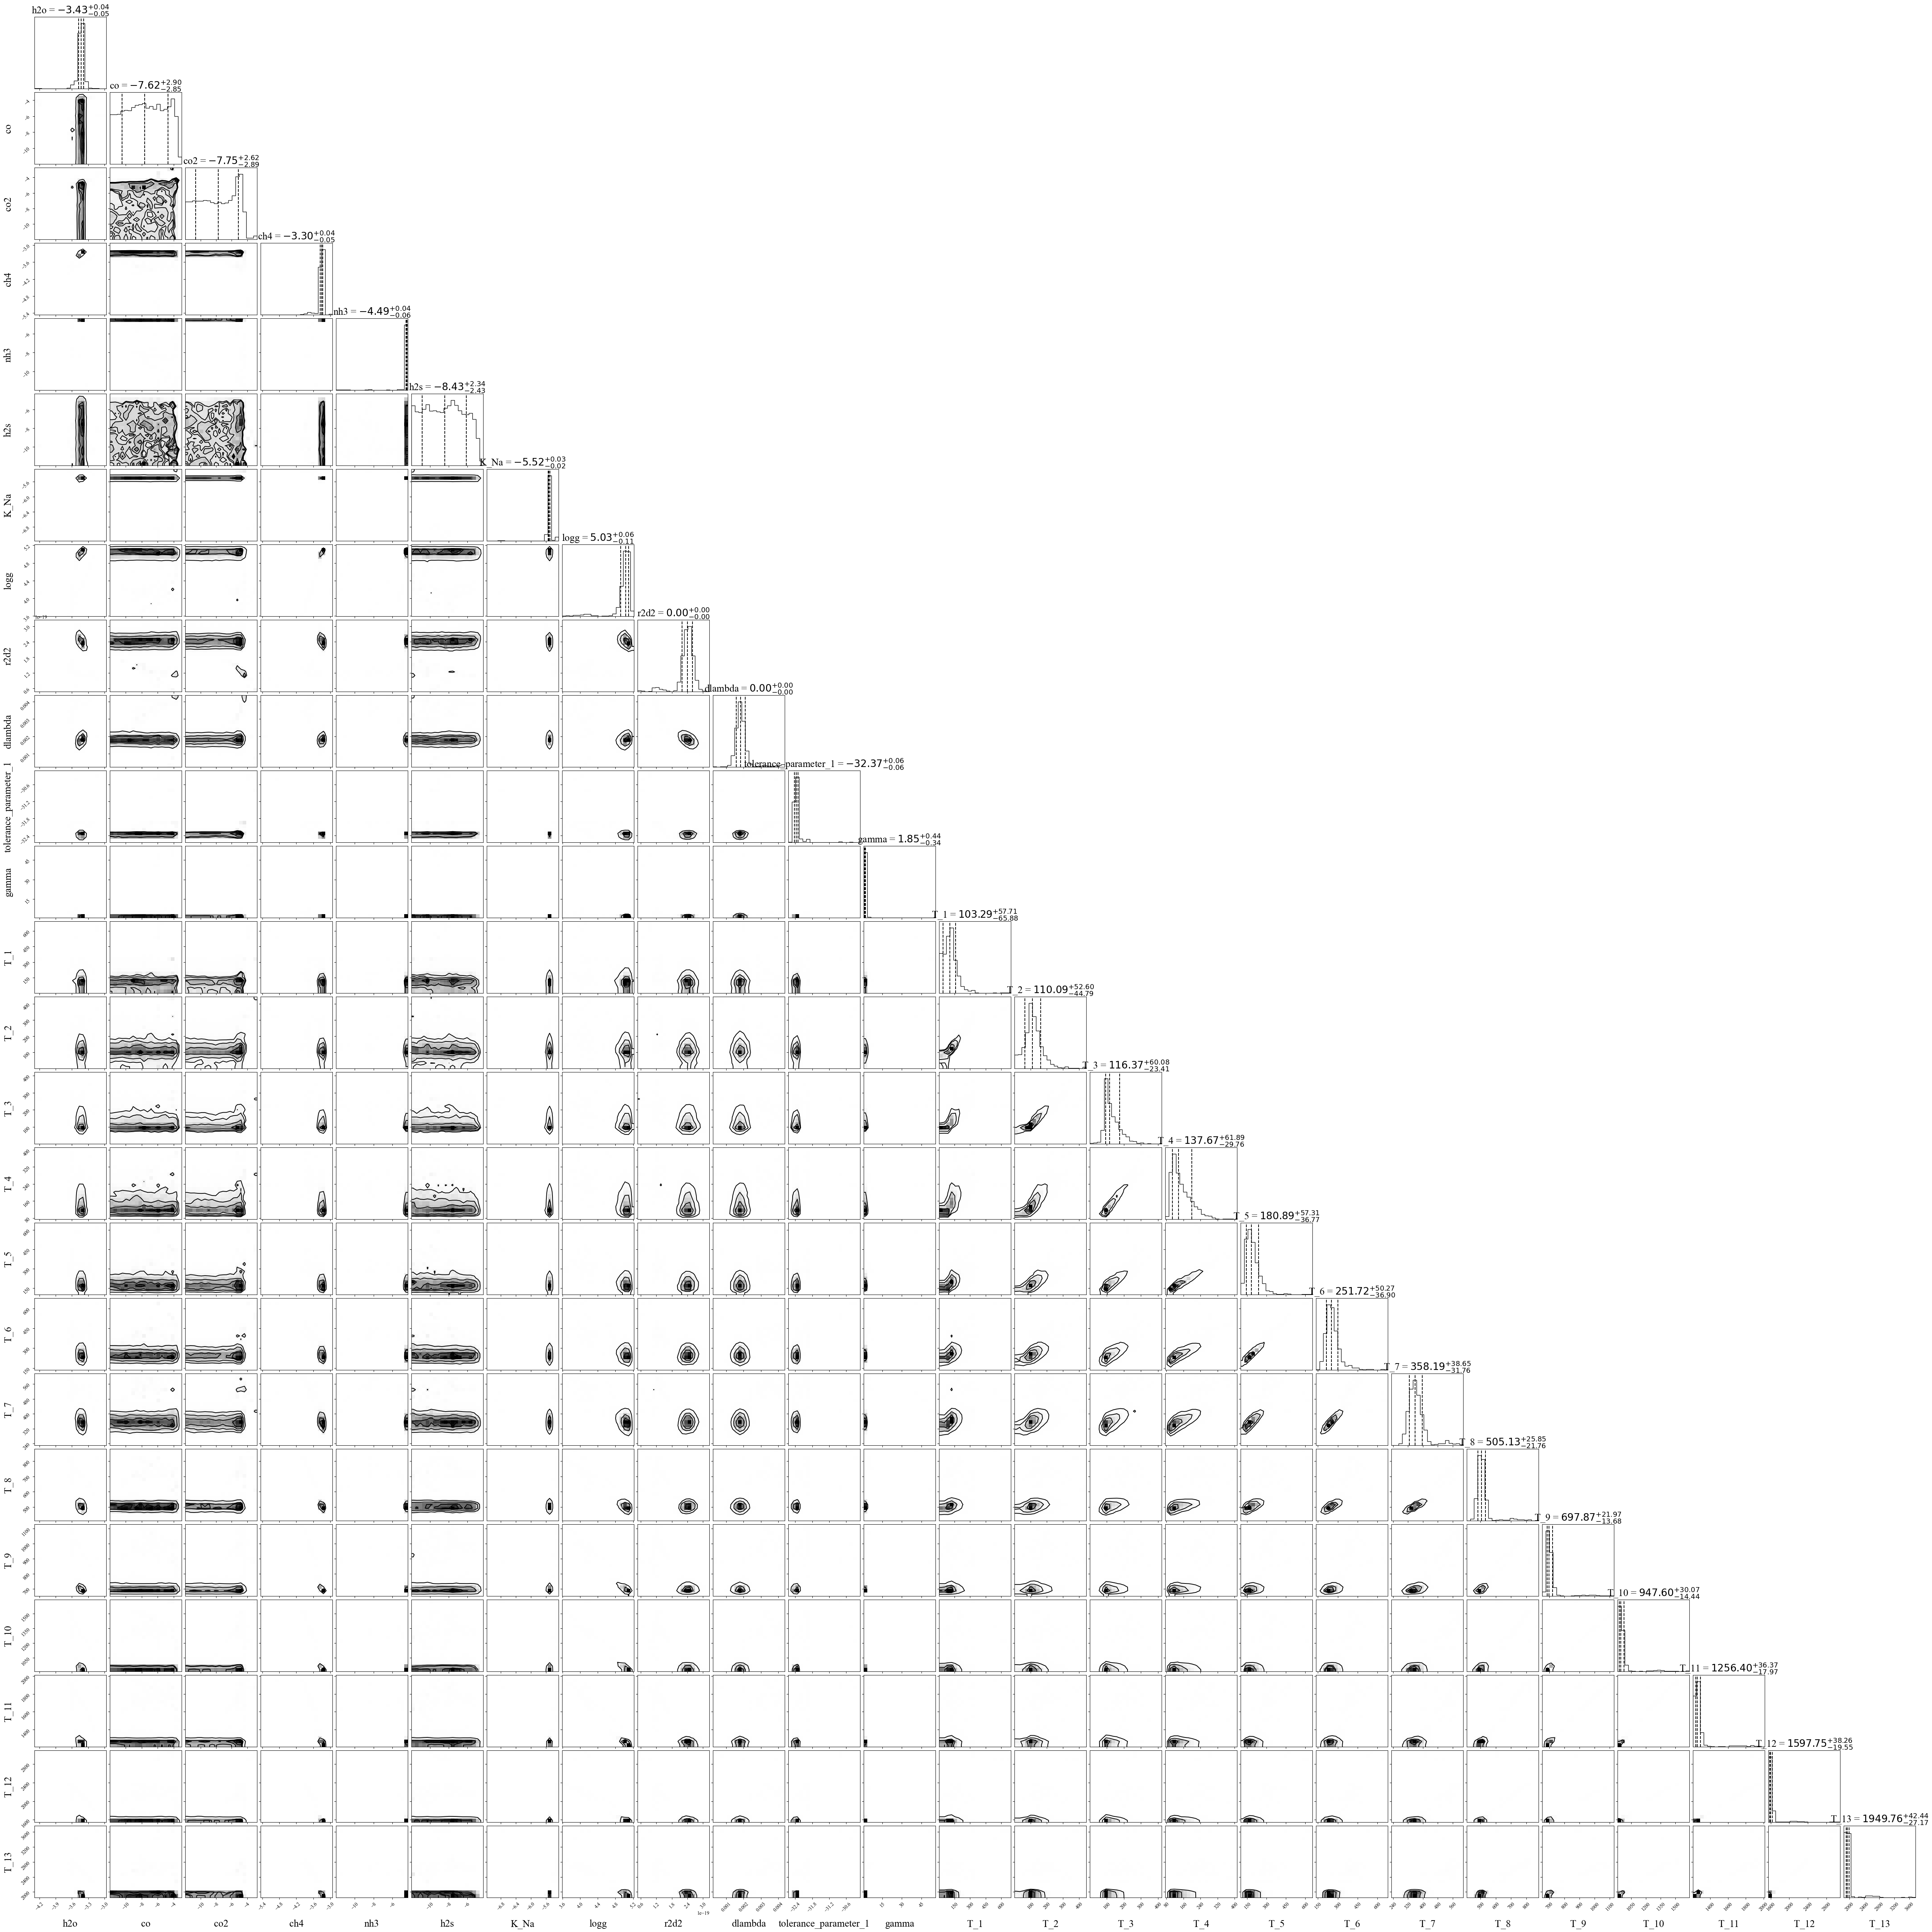

In [13]:
fig = corner.corner(samples,scale_hist=False,plot_datapoints =False,\
                    labels=all_params,\
                    quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 20},\
                    label_kwargs={"fontsize": 20})

## 6. Plot the Fitted Spectrum
generate the best-fit model spectrum and compute credible intervals from the posterior samples to compare with the observed data.

In [25]:
#get diagnostics along with the spectrum
gnostics = 0
# Now run the model again to get your model spectrum and process to make it look like the data

trimspec, photspec, tauspec,cfunc = test_module.modelspec(theta_max_end,re_params,runargs,gnostics)
wave,topspec=proc_spec(inputspec=trimspec, theta=params_instance, re_params=re_params, args_instance=args_instance, do_scales=args_instance.do_scales, do_shift=args_instance.do_shift)


In [15]:
# Now grab 500 random draws from the posterior
pltspec = np.zeros((500,runargs.obspec[0,:].size))
samp= np.empty(ndim)
samples = flatendchain
sid = np.zeros(500)
for i in range (0,500):
    sid[i]= np.random.randint(0,high = len(samples))
    samp = samples[int(sid[i]),:]
    
    trimspec, photspec, tauspec,cfunc = test_module.modelspec(samp,re_params,runargs,gnostics)
    pltspec[i,:] = proc_spec(inputspec=trimspec, theta=params_instance, re_params=re_params, args_instance=args_instance, do_scales=args_instance.do_scales, do_shift=args_instance.do_shift)[1]

# get the intervals for the distribution of model spectra
specdist = np.empty([runargs.obspec[0].size,5])
for i in range(0,runargs.obspec[0].size):
    junk = pltspec[:,i]
    junk2 = np.percentile(junk, [2.4,16, 50, 84,97.6],axis=0)
    junk3 = np.array(junk2)
    specdist[i,:] = junk3[:]


Text(0.5, 0, 'Wavelength / $\\mu m$')

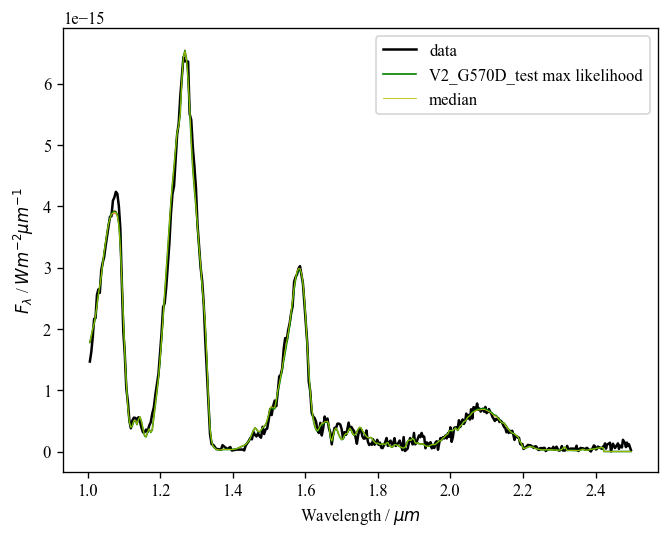

In [32]:
# plot the spectra
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=120)


d1, = plt.plot(runargs.obspec[0,:],runargs.obspec[1,:],'k-',label = "data")
t1, = plt.plot(runargs.obspec[0,:],topspec,'g-',linewidth=1, label = runname+" max likelihood")

r1, = plt.plot(runargs.obspec[0],specdist[:,2],'y-',linewidth=0.5, label = "median")
#plt.fill_between(obspec[0],specdist[:,0],specdist[:,4],facecolor='red',alpha=0.2)
plt.fill_between(runargs.obspec[0],specdist[:,1],specdist[:,3],facecolor='red',alpha=0.5)
#plt.fill_between(obspec[0,:],obspec[1,:]-obspec[2,:],obspec[1,:]+obspec[2,:],facecolor='red',alpha=0.2)


plt.legend(handles=[d1,t1,r1])


plt.ylabel(r'$ F_{\lambda}$ / $Wm^{-2} \mu m^{-1}$')
plt.xlabel('Wavelength / $\mu m$')
#plt.savefig(runname+"_SPAG_SPEC.png",format='png', dpi=320))